# `12-langgraph_rag.ipynb`

# RAG w/ Langgraph

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from pprint import pprint

# 1. Loader (웹문서)
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer  # pip install beautifulsoup4

loader = WebBaseLoader(
    # 문서 출처 URL
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/', ),
    # 웹페이지 안에서 필요한 정보만 선택
    bs_kwargs={
        'parse_only': SoupStrainer(class_=['post-content']) 
    }
    # header_template={}
)
docs = loader.load()

# 2. Splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splitted_docs = splitter.split_documents(docs)
print(len(splitted_docs))

# 3. Embedding Model
from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(model='text-embedding-3-small')  # small <-> large

# 4. Vectorstore (지금은 FAISS -> 클라우드-Pinecone)
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

63


In [12]:
from langchain import hub

prompt = hub.pull('rlm/rag-prompt')

for m in prompt.messages:
    m.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [21]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4.1', temperature=0)

# State
from langchain_core.documents import Document
from typing_extensions import TypedDict, List

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Node
# 검색 노드
def retrieve(state: State):
    # [ Document * 4 ]
    retrieved_docs = vectorstore.similarity_search(state['question'], k=4)

    # 나머지 return 하지 않은 state 항목들은, 알아서 그대로 감 (question, answer 는 알아서 그대로 나감)
    return { 'context': retrieved_docs, }


# 답변 생성노드
def generate(state: State):
    # Document 객체의 필요없는 정보는 다 빼고, 내용에 해당하는 page_content 만 모아서 넘기면 토큰 절약 가능.
    context_str = ''
    for doc in state['context']:
        context_str += doc.page_content + '\n------------------------\n'
    
    question_with_context = prompt.invoke({'question': state['question'], 'context': context_str})
    response = llm.invoke(question_with_context)
    return {'answer': response.content}

# Graph
from langgraph.graph import StateGraph, START, END
builder = StateGraph(State)

builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

# 출력
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

*메세지 스트리밍*

In [22]:
final_state = graph.invoke({'question': '에이전트 시스템에 대해 알려줘!'})

final_state['answer']

'에이전트 시스템은 다양한 자원을 활용해 주어진 작업을 자동으로 수행하는 소프트웨어 구조입니다. 예를 들어, 인터넷 검색, 장기 메모리 관리, 하위 에이전트에게 작업 위임, 파일 출력 등 여러 기능을 조합해 효율적으로 문제를 해결합니다. 또한, 자신의 행동을 지속적으로 평가하고 개선하며, 최적의 결과를 내기 위해 단계별로 작업을 수행합니다.'

## RAG +a

- Metadata 편집
- Query 분석 - 보완

In [ ]:
# 문세 63개 중 1/3 지점
third = len(splitted_docs) // 3

for idx, doc in enumerate(splitted_docs):
    if idx < third:
        doc.metadata['section'] = '전반부'
    elif idx < third * 2:
        doc.metadata['section'] = '중반부'
    else:
        doc.metadata['section'] = '후반부'
        
splitted_docs[0].metadata

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': '전반부'}

In [ ]:
# State를 더 빡빡하게 정의하기 위해, 위에 따로 정의한 클래스 Search

from typing import Literal  # 말 그대로 
from typing_extensions import Annotated  # 할말이 좀 더 있다

class Search(TypedDict):
    """vectorstore Search Query"""
    # 1. 타입, 2. ... -> NOT NULL 3. 설명(AI용)
    query: Annotated[str, ..., 'Search query to run']
    section: Annotated[
        Literal['전반부', '중반부', '후반부'], 
        ..., 
        'Section to query'
    ]
    
class MyState(TypedDict):
    question: str
    query: Search  
    context: List[Document]
    answer: str

In [29]:
# Node

def analyze_query(state: MyState):
    # Search 클래스에 맞춰 사용자 question 을 {query, section}로 바꿈
    s_llm = llm.with_structured_output(Search)
    query = s_llm.invoke(state['question'])
    return {'query': query}

def retrieve(state: MyState):
    query = state['query']
    docs = vectorstore.similarity_search(
        query['query'],
        # LLM이 판단한 section과 실제 문서조각의 section이 맞을 경우에만 검색
        filter=lambda metadata: metadata.get('section') == query['section'],
    )
    return {'context': docs}

def generate(state: MyState):
    # Token 아끼기 위해, 내용만 추려서 문자열로 만들기
    doc_str = ''
    for doc in state['context']:
        doc_str += doc.page_content + '\n======================='
        
    question_with_context = prompt.invoke({'question': state['question'], 'context': doc_str})
    res = llm.invoke(question_with_context)
    
    return {'answer': res.content}

builder = StateGraph(MyState)
builder.add_node('analyze_query', analyze_query)
builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'analyze_query')
builder.add_edge('analyze_query', 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

In [30]:
graph.invoke({'question': '작업분배 뭐냐'})

{'question': '작업분배 뭐냐',
 'query': {'query': '작업분배 정의', 'section': '\x1c전체'},
 'context': [],
 'answer': '작업분배는 여러 작업이나 업무를 여러 사람 또는 팀에게 나누어 할당하는 것을 의미합니다. 이를 통해 효율적으로 일을 처리하고 각자의 역할을 명확히 할 수 있습니다.'}

## 대화형 RAG

In [42]:
from dotenv import load_dotenv

load_dotenv()

True

In [43]:
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer  # pip install beautifulsoup4
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_pinecone import PineconeVectorStore

loader = WebBaseLoader(
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/', ),
    bs_kwargs={
        'parse_only': SoupStrainer(class_=['post-content']) 
    }
)
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splitted_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings(model='text-embedding-3-small')  # small <-> large

index_name = 'gaida-1st'

# 밑에 꺼랑 같은 방법
# pc = Pinecone()
# if pc.has_index(index_name):
#     index = pc.Index(index_name)
#     vectorstore = PineconeVectorStore(index=index, embedding=embedding)
# else:
#     print('No index name', index_name)

# 1회 실행하면, 실제 데이터가 들어가서 영주 저장 됨.
# vectorstore = PineconeVectorStore.from_documents(
#     splitted_docs,
#     index_name=index_name,
#     embedding=embedding
# )

In [44]:
from langchain_core.tools import tool

@tool(response_format='content_and_artifact')  # 2개를 return 한다
def retrieve(query: str):
    """Retrieve information related to a query

    Args:
        query (str): Query to search
    """
    # 원본 Document list (artifact)
    docs = vectorstore.similarity_search(query, k=3)
    # 편집한 텍스트 (content)
    result_text = '\n\n'.join(
        (f'Source: {doc.metadata}\nContent: {doc.page_content}')
        for doc in docs
    )
    return result_text, docs

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START, END

llm = ChatOpenAI(model='gpt-4.1-nano', temperature=0)

# Node
def query_or_respond(state: MessagesState):
    """도구 호출을 하거나, 최종 응답을 한다."""
    llm_with_tools = llm.bind_tools([retrieve])
    
    res = llm_with_tools.invoke(state['messages'])
    return {'messages': [res]}

tools = ToolNode([retrieve])

def generate(state: MessagesState):
    """응답 생성"""
    tool_messages = []
    for msg in reversed(state['messages']):  # 메세지 목록을 뒤집음: 최신 메세지부터 순회
        if msg.type == 'tool':
            tool_messages.append(msg)
        else:
            break
    tool_messages.reverse()
    docs_content = '\n\n'.join(doc.construct for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    # 필요 없는 Tool 메세지들을 제외하고, AI, Human, System 메세지만 모아서 정리
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import MessagesState, StateGraph
builder = StateGraph(MessagesState)  # 'messages'

# builder.add_node('query_or_respond', query_or_respond)  # 아래와 같은 결과
builder.add_node(query_or_respond)
builder.add_node(tools)
builder.add_node(generate)

# builder.set_entry_point('query_or_respond')  # 아래와 같은 말
builder.add_edge(START, 'query_or_respond')
builder.add_conditional_edges(
    'query_or_respond', 
    tools_condition,
    {END: END, 'tools': 'tools'}  # 정확하게 다음 Node를 지정할 수 있음
)
builder.add_edge('tools', 'generate')
builder.add_edge('generate', END)


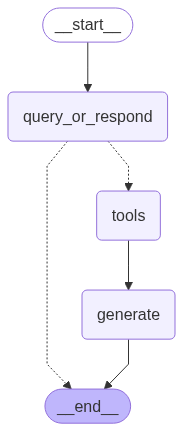

In [47]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
# 위 그래프를 실행하려면?
input_state = {
    'messages': [
        {'role': 'user', 'content': 'Task Decomposition 이 뭐야?'}
    ]
}
res = graph.invoke(input_state)

for msg in res['messages']:
    msg.pretty_print()

TypeError: sequence item 0: expected str instance, method found

## 대화 기록 저장하기 (Langgraph Memory)

In [49]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# 위에 정의 된 builder 사용

graph = builder.compile(checkpointer=memory)

In [50]:
config = {
    'configurable': {'thread_id': '123'}
}

input_state = {
    'messages':[
        {'role': 'user', 'content': 'Task Decomposition 이 뭐야?'}
    ]
}

res = graph.invoke(input_state, config)

for msg in res['messages']:
    msg.pretty_print()

TypeError: sequence item 0: expected str instance, method found